# Group Project: Predicting Alcohol consumptiom - Binary Model

## 1. Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as mtick
import seaborn as sns
import itertools
import time
import statsmodels.api as sm
import scikitplot as skplt 

#sklearn for modeling
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier #Decision Tree algorithm
from sklearn.model_selection import train_test_split #Data split function
from sklearn.preprocessing import LabelEncoder #OneHotEncoding
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import scale 
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

#Decision tree plot
import pydotplus
from IPython.display import Image 

from collections import Counter

#add all necessary libraries here

## 2. Import data

In [2]:
#import the data into a Pandas dataframe and show it
data_mat = pd.read_csv('student-mat.csv')
data_por = pd.read_csv('student-por.csv')

2 datasets for 2 subjects Math and Portugal are merged into one dataset. Then all duplicates are dropped.

In [3]:
data = pd.concat([data_mat,data_por], ignore_index=True)
data.drop_duplicates(subset=["school","sex","age","address","famsize","Pstatus","Medu","Fedu","Mjob","Fjob","reason","nursery","internet"],keep='first',inplace=True)
data.head().style

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10


## 3. Exploratory data analysis (EDA)

In [4]:
data.describe().round()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,662.0,662.0,662.0,662.0,662.0,662.0,662.0,662.0,662.0,662.0,662.0,662.0,662.0,662.0,662.0,662.0
mean,17.0,2.0,2.0,2.0,2.0,0.0,4.0,3.0,3.0,2.0,2.0,4.0,5.0,11.0,11.0,11.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,7.0,3.0,4.0,4.0
min,15.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,3.0,0.0,0.0
25%,16.0,2.0,1.0,1.0,1.0,0.0,4.0,3.0,2.0,1.0,1.0,2.0,0.0,8.0,9.0,9.0
50%,17.0,2.0,2.0,1.0,2.0,0.0,4.0,3.0,3.0,1.0,2.0,4.0,3.0,10.0,11.0,11.0
75%,18.0,4.0,3.0,2.0,2.0,0.0,5.0,4.0,4.0,2.0,3.0,5.0,8.0,13.0,13.0,13.0
max,22.0,4.0,4.0,4.0,4.0,3.0,5.0,5.0,5.0,5.0,5.0,5.0,75.0,19.0,19.0,20.0


We can't see any outliers in the dataset.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 662 entries, 0 to 1037
Data columns (total 33 columns):
school        662 non-null object
sex           662 non-null object
age           662 non-null int64
address       662 non-null object
famsize       662 non-null object
Pstatus       662 non-null object
Medu          662 non-null int64
Fedu          662 non-null int64
Mjob          662 non-null object
Fjob          662 non-null object
reason        662 non-null object
guardian      662 non-null object
traveltime    662 non-null int64
studytime     662 non-null int64
failures      662 non-null int64
schoolsup     662 non-null object
famsup        662 non-null object
paid          662 non-null object
activities    662 non-null object
nursery       662 non-null object
higher        662 non-null object
internet      662 non-null object
romantic      662 non-null object
famrel        662 non-null int64
freetime      662 non-null int64
goout         662 non-null int64
Dalc          662 n

We observe:
- No missing values (all variables show 1100 entries)
- no NaN values 
- some redundant variables (e.g. OBS#)
- Many variables are of type object, which is not suitable for modelling

### Preliminary Data Visualization

#### Correlation between all variables

First, let's take a look at the correlations between all the variables in the dataset.

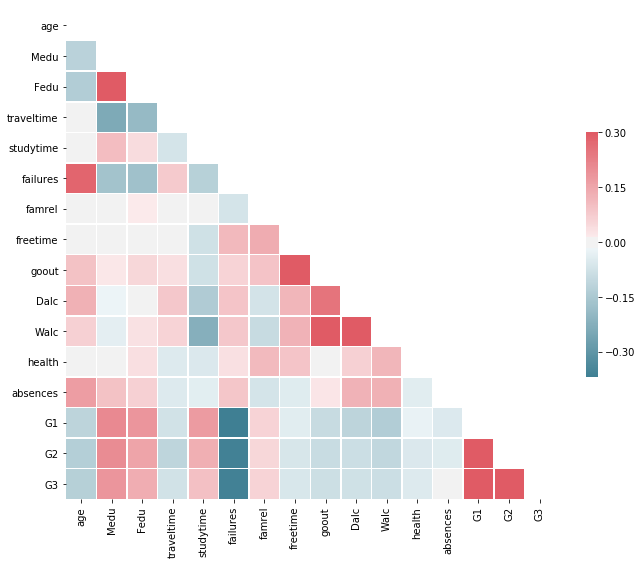

In [6]:
# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

**Positive correlation** 
* The values of each grade (G1, G2 and G3) were found to correlate with one another.
* The values of workday consumption of alcohol (Dalc), weekend consumption of alcohol (Walc) and going out (goout) were found to correlate.
* There was also a positive correlation between mother’s education (Medu) and father’s education (Fedu).
* The amount of going out time (goout) correlates with the amount of free time (freetime).
* Student's age (age) correlates with amount of failures (failures)

**Negative correlation**
* The values of each grade (G1, G2 and G3) were found to correlate negatively with failures.
* Likewise, a negative correlation between the workday consumption of alcohol (Dalc) and weekly study time (studytime) was present.

#### Alcohol consumption among students during weekends and weekdays

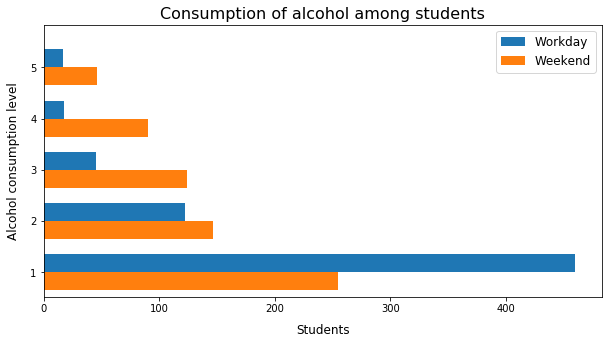

In [7]:
data['AmtW']=1
data['AmtD']=1
cw = data[['Walc','AmtW']]
cd = data[['Dalc','AmtD']]

# count the occurrences of each point
cw = cw.groupby('Walc').count()
# create a list of the sizes, here multiplied by 10 for scale
cd = cd.groupby('Dalc').count()

y_pos = np.arange(len(cw))                  
width=0.35                

fig,ax = plt.subplots(figsize=(10,5))

ax.barh(y_pos+width, cd.AmtD, width, label='Workday')
ax.barh(y_pos, cw.AmtW, width, label='Weekend')
#ax.barh(y_pos+width, cd.AmtD, width, label='Workday')
ax.set(yticks=y_pos + width/2, yticklabels=[1,2,3,4,5], ylim=[2*width - 1, len(cw)])
ax.legend(fontsize=12)
ax.set_xlabel("Students", fontsize=12, labelpad = 10)
ax.set_ylabel("Alcohol consumption level", fontsize=12, labelpad = 10)
plt.title('Consumption of alcohol among students', fontsize=16)

plt.show()

* Students tend to **drink more on the weekends** compared to weekdays.

* This plot shows that the data set is **heavily imbalanced** with fewer observations of high alcohol consumption students. Rebalance procedure for training dataset might be necessary.

#### Alcohol consumption by gender

D:\Application\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


([<matplotlib.axis.XTick at 0x1f80e725f28>,
 <a list of 5 Text xticklabel objects>)

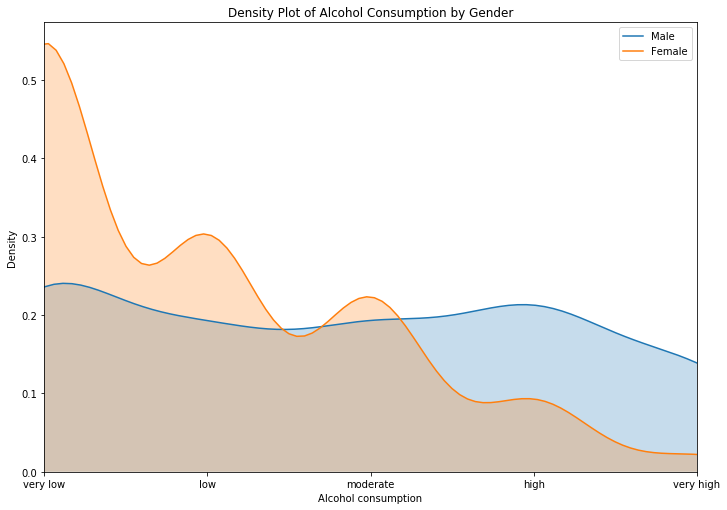

In [8]:
# Alcohol consumption by gender
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sns.kdeplot(data.loc[data['sex'] == 'M', 'Walc'], label = 'Male', shade = True)
sns.kdeplot(data.loc[data['sex'] == 'F', 'Walc'], label = 'Female', shade = True)
plt.xlabel('Alcohol consumption'); plt.ylabel('Density'); plt.title('Density Plot of Alcohol Consumption by Gender');
plt.xlim([1,5])
tick_val = [1, 2, 3, 4, 5]
tick_lab = ['very low', 'low', 'moderate', 'high', 'very high']
plt.xticks(tick_val,tick_lab)

The amount of alcohol consumed differed significantly by gender. Female students tend to consume less alcohol compared to their male counterparts.

#### Final grade performance's relation with alcohol consumption and study time

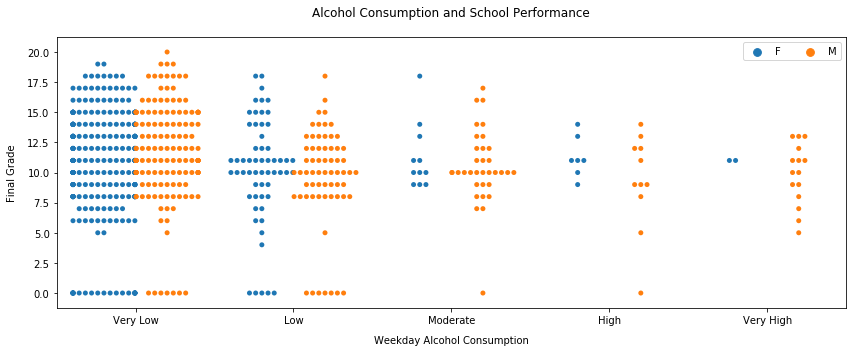

In [9]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.swarmplot(x='Dalc',y='G3',hue='sex', data=data,dodge=True)
ax.set_xlabel("Weekday Alcohol Consumption", fontsize=10, labelpad = 10)
ax.set_ylabel("Final Grade", fontsize=10, labelpad = 10)
ax.set_xticklabels(['Very Low','Low','Moderate','High','Very High'],rotation=0)
ax.set_title('Alcohol Consumption and School Performance\n')
ax.legend(ncol=2,loc='upper right')
fig.tight_layout()

* It can be seen from this swarm plot that students who consume less alcohol tends to perform better in the test.

* This result is in line with hypothesis #2, showing a negative correlation between alcohol consumption and grade.

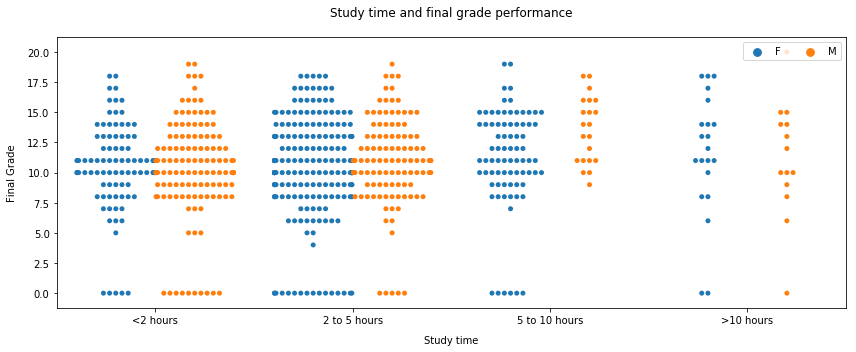

In [10]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.swarmplot(x='studytime',y='G3',hue='sex', data=data,dodge=True)
ax.set_xlabel("Study time", fontsize=10, labelpad = 10)
ax.set_ylabel("Final Grade", fontsize=10, labelpad = 10)
ax.set_xticklabels(['<2 hours','2 to 5 hours','5 to 10 hours','>10 hours'],rotation=0)
ax.set_title('Study time and final grade performance\n')
ax.legend(ncol=2,loc='upper right')
fig.tight_layout()

Most students spend less than 2 hours to 5 hours of study time per week. However, from the plot, study time doesn't really correlate with high final grade score.

#### Singles' vs in-relationship students' test performance

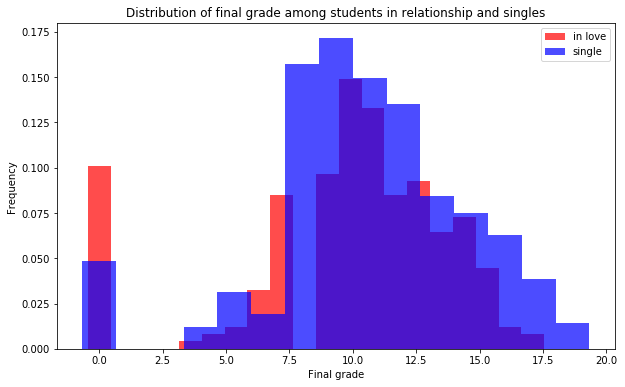

In [11]:
fig, axs = plt.subplots(1,1, figsize=(10,6))

#get relative count of in-love students and plot
results_yes, edges_yes = np.histogram(data.G3.loc[data['romantic'] == 'yes'], bins=20, density=True)
binWidth_yes = edges_yes[1] - edges_yes[0]
plt.bar(edges_yes[:-1], results_yes*binWidth_yes, binWidth_yes, alpha=0.7, color='red', label='in love')

#get relative count of singles and plot
results_no, edges_no = np.histogram(data.G3.loc[data['romantic'] == 'no'], bins=15, density=True)
binWidth_no = edges_no[1] - edges_no[0]
plt.bar(edges_no[:-1], results_no*binWidth_no, binWidth_no, alpha=0.7, color= 'blue', label='single')

plt.title('Distribution of final grade among students in relationship and singles')
plt.xlabel('Final grade')
plt.ylabel('Frequency');
plt.legend();

It can be seen here that **single students perform much better** in the finals than students who are in love. Students who are in love also fail the finals 2 times more often than single students. Romantic life and student life seems to be having a hard time together.

## Data Preprocessing

Weekday's alcohol consumption `Dalc` and weekend's alcohol consumption `Walc` is combined into a new variable, whole week alcohol consmumption `WeekAlc`. This will be used later as the response variable.

In [12]:
data['WeekAlc'] = data['Dalc'] + data['Walc']

Then, one-hot-encoding is performed for categorical variables.

In [13]:
dummies = pd.get_dummies(data[['school','sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian']])
dummies.head()

,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,...,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
0,1,0,1,0,0,1,1,0,1,0,...,0,0,1,1,0,0,0,0,1,0
1,1,0,1,0,0,1,1,0,0,1,...,1,0,0,1,0,0,0,1,0,0
2,1,0,1,0,0,1,0,1,0,1,...,1,0,0,0,0,1,0,0,1,0
3,1,0,1,0,0,1,1,0,0,1,...,0,1,0,0,1,0,0,0,1,0
4,1,0,1,0,0,1,1,0,0,1,...,1,0,0,0,1,0,0,1,0,0


For binary categorical variables, one of the two encoded variables is dropped as the meaning is already conveyed in the other variable (1 or 0).

In [14]:
dummies = dummies.drop(['school_GP','sex_F', 'address_R', 'famsize_GT3', 'Pstatus_A'], axis=1).astype('int64')
dummies.head()

,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,...,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
0,0,0,1,0,0,1,0,0,0,0,...,0,0,1,1,0,0,0,0,1,0
1,0,0,1,0,1,1,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0
2,0,0,1,1,1,1,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0
3,0,0,1,0,1,0,1,0,0,0,...,0,1,0,0,1,0,0,0,1,0
4,0,0,1,0,1,0,0,1,0,0,...,1,0,0,0,1,0,0,1,0,0


In [15]:
data = data.drop(['school','sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian'], axis=1)
data = pd.concat([data, dummies], axis = 1)

In [16]:
items = ['schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
data[items] = data[items].replace({'yes':'1', 'no':'0'}).astype('int64')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 662 entries, 0 to 1037
Data columns (total 49 columns):
age                  662 non-null int64
Medu                 662 non-null int64
Fedu                 662 non-null int64
traveltime           662 non-null int64
studytime            662 non-null int64
failures             662 non-null int64
schoolsup            662 non-null int64
famsup               662 non-null int64
paid                 662 non-null int64
activities           662 non-null int64
nursery              662 non-null int64
higher               662 non-null int64
internet             662 non-null int64
romantic             662 non-null int64
famrel               662 non-null int64
freetime             662 non-null int64
goout                662 non-null int64
Dalc                 662 non-null int64
Walc                 662 non-null int64
health               662 non-null int64
absences             662 non-null int64
G1                   662 non-null int64
G2            

In [17]:
data['WeekAlc'] = np.where(data['WeekAlc'] > 5, 1,0)

In [18]:
data.head(10).style
print("Dimensions of modified data:", data.shape)

Dimensions of modified data: (662, 49)


In [19]:
y = data['WeekAlc'] #define target variable 
X = data.loc[:, data.columns.difference(['Walc', 'Dalc', 'WeekAlc'])] #define feature matrix

## 4. Feature Selection

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

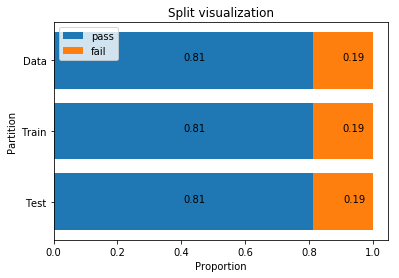

In [21]:
train_dist = y_train.value_counts() / len(y_train) #normalize absolute count values for plotting
test_dist = y_test.value_counts() / len(y_test)
data_dist = data['WeekAlc'].value_counts() / len(data)

fig, ax = plt.subplots()

ax.barh(['Test','Train','Data'], [test_dist[0], train_dist[0], data_dist[0]], color='#1f77b4', label='pass')
ax.barh(['Test','Train','Data'], [test_dist[1], train_dist[1], data_dist[1]], left=[test_dist[0], train_dist[0], data_dist[0]], color='#ff7f0e', label='fail')
ax.set_title('Split visualization')
ax.legend(loc='upper left')
plt.xlabel('Proportion')
plt.ylabel('Partition')

#plot bar values
for part, a, b in zip(['Test', 'Train','Data'], [test_dist[0], train_dist[0], data_dist[0]], [test_dist[1], train_dist[1], data_dist[1]]):
    plt.text(a/2, part, str(np.round(a, 2)))
    plt.text(b/2+a, part, str(np.round(b, 2)));

### Lasso Regression

In [22]:
alphas = 10**np.linspace(10,-2,100)*0.5
alphas

array([5.00000000e+09, 3.78231664e+09, 2.86118383e+09, 2.16438064e+09,
       1.63727458e+09, 1.23853818e+09, 9.36908711e+08, 7.08737081e+08,
       5.36133611e+08, 4.05565415e+08, 3.06795364e+08, 2.32079442e+08,
       1.75559587e+08, 1.32804389e+08, 1.00461650e+08, 7.59955541e+07,
       5.74878498e+07, 4.34874501e+07, 3.28966612e+07, 2.48851178e+07,
       1.88246790e+07, 1.42401793e+07, 1.07721735e+07, 8.14875417e+06,
       6.16423370e+06, 4.66301673e+06, 3.52740116e+06, 2.66834962e+06,
       2.01850863e+06, 1.52692775e+06, 1.15506485e+06, 8.73764200e+05,
       6.60970574e+05, 5.00000000e+05, 3.78231664e+05, 2.86118383e+05,
       2.16438064e+05, 1.63727458e+05, 1.23853818e+05, 9.36908711e+04,
       7.08737081e+04, 5.36133611e+04, 4.05565415e+04, 3.06795364e+04,
       2.32079442e+04, 1.75559587e+04, 1.32804389e+04, 1.00461650e+04,
       7.59955541e+03, 5.74878498e+03, 4.34874501e+03, 3.28966612e+03,
       2.48851178e+03, 1.88246790e+03, 1.42401793e+03, 1.07721735e+03,
      

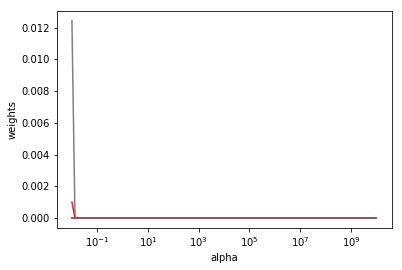

In [23]:
lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []


for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train.astype(float)), y_train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights');

In [24]:
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True) #why alphas = None
lassocv.fit(X_train, y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
mean_squared_error(y_test, lasso.predict(X_test))

0.11574178584243547

In [25]:
pd.Series(lasso.coef_, index=X.columns)

AmtD                 0.000000
AmtW                 0.000000
Fedu                -0.000000
Fjob_at_home        -0.005377
Fjob_health          0.060179
Fjob_other          -0.000000
Fjob_services        0.025780
Fjob_teacher        -0.063369
G1                  -0.005620
G2                   0.000000
G3                   0.000000
Medu                -0.000000
Mjob_at_home         0.025570
Mjob_health         -0.069765
Mjob_other          -0.000000
Mjob_services       -0.000000
Mjob_teacher         0.000000
Pstatus_T            0.013054
absences             0.008395
activities          -0.000000
address_U           -0.040071
age                  0.000000
failures             0.000000
famrel              -0.024868
famsize_LE3          0.000000
famsup              -0.011154
freetime            -0.000000
goout                0.088367
guardian_father      0.011061
guardian_mother     -0.032773
guardian_other       0.000000
health               0.011142
higher              -0.000000
internet  

## Data Modelling

In [26]:
# Generate series of CV variables
coefs = pd.Series(lasso.coef_, index=X.columns)
coefs.sort_values(ascending = False)
# Convert the resulting pandas series to a pandas dataframe
coefs = coefs.to_frame('Value')

# Get the names of indexes for which column Value is 0
indexNames = coefs[ coefs['Value']==0].index
# Delete the corresponding rows from the original dataFrame
coefs.drop(indexNames , inplace=True)
coefs.sort_values(by='Value', ascending = False)
coefs

,Value
Fjob_at_home,-0.005377
Fjob_health,0.060179
Fjob_services,0.025780
Fjob_teacher,-0.063369
G1,-0.005620
Mjob_at_home,0.025570
Mjob_health,-0.069765
Pstatus_T,0.013054
absences,0.008395
address_U,-0.040071


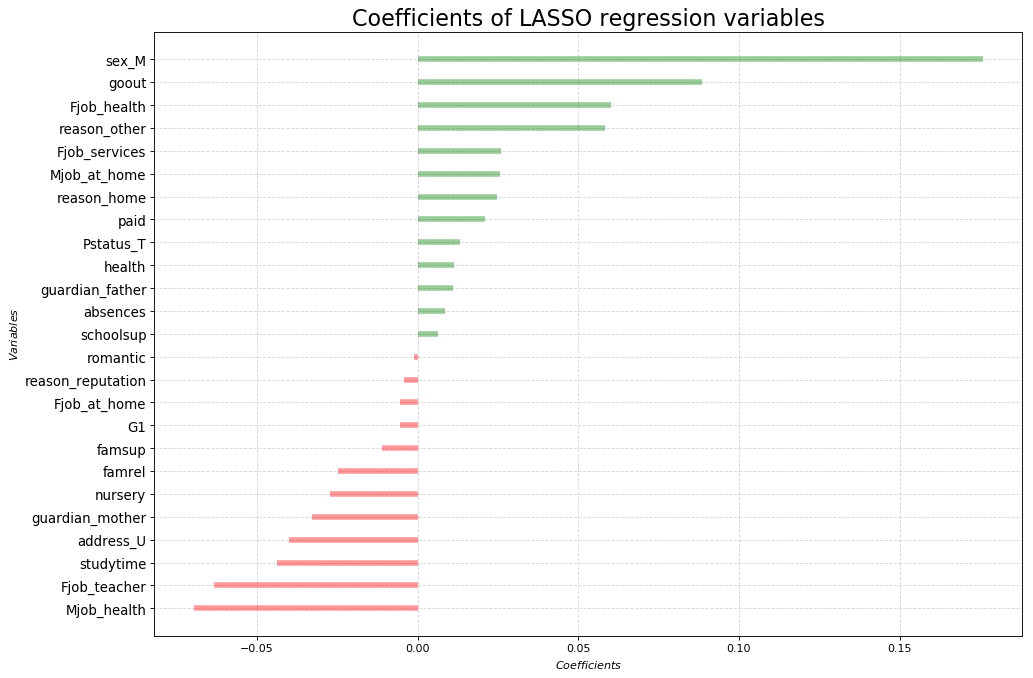

In [27]:
# Prepare Data
x = coefs.loc[:, ['Value']]

coefs['colors'] = ['red' if x < 0 else 'green' for x in coefs['Value']]
coefs.sort_values(by='Value', ascending = True, inplace=True)

# Draw plot
plt.figure(figsize=(14,10), dpi= 80)
plt.hlines(y=coefs.index, xmin=0, xmax=coefs['Value'], color=coefs.colors, alpha=0.4, linewidth=5)

# Decorations
plt.gca().set(ylabel='$Variables$', xlabel='$Coefficients$')
plt.yticks(coefs.index, coefs.index, fontsize=12)
plt.title('Coefficients of LASSO regression variables', fontdict={'size':20})
plt.grid(linestyle='--', alpha=0.5)
plt.show()

In [28]:
X_new = data[coefs.index]

In [29]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y, test_size=0.3, random_state=1)

In [30]:
smote = SMOTE(ratio='minority')
X_sm, y_sm = smote.fit_sample(X_train_new, y_train_new) #ONLY APPLIED TO TRAINING!!!

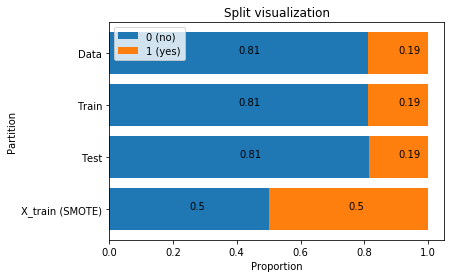

In [31]:
train_dist = y_train_new.value_counts() / len(y_train_new) #normalize absolute count values for plotting
test_dist = y_test_new.value_counts() / len(y_test_new)
data_dist = y.value_counts() / len(y)
smote_dist = pd.Series(y_sm).value_counts() / len(pd.Series(y_sm))

fig, ax = plt.subplots()

ax.barh(['X_train (SMOTE)','Test','Train','Data'], [smote_dist[0], test_dist[0], train_dist[0], data_dist[0]], color='#1f77b4', label='0 (no)')
ax.barh(['X_train (SMOTE)','Test','Train','Data'], [smote_dist[1], test_dist[1], train_dist[1], data_dist[1]], left=[smote_dist[0], test_dist[0], train_dist[0], data_dist[0]], color='#ff7f0e', label='1 (yes)')
ax.set_title('Split visualization')
ax.legend(loc='upper left')
plt.xlabel('Proportion')
plt.ylabel('Partition')

#plot bar values
for part, a, b in zip(['X_train (SMOTE)', 'Test', 'Train','Data'], [smote_dist[0], test_dist[0], train_dist[0], data_dist[0]], [smote_dist[1], test_dist[1], train_dist[1], data_dist[1]]):
    plt.text(a/2, part, str(np.round(a, 2)))
    plt.text(b/2+a, part, str(np.round(b, 2)));

In [32]:
print('Original label %s' % Counter(y_train_new))
print('SMOTE label %s' % Counter(y_sm))

Original label Counter({0: 376, 1: 87})
SMOTE label Counter({0: 376, 1: 376})


### Decision Tree

In [33]:
#Define Decision tree classifier with some default parameters
clf = DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=5, min_samples_leaf=3)

#Fit the training data 
clf.fit(X_sm, y_sm)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [34]:
#Use classifier to predict labels
y_pred_bal = clf.predict(X_test_new)

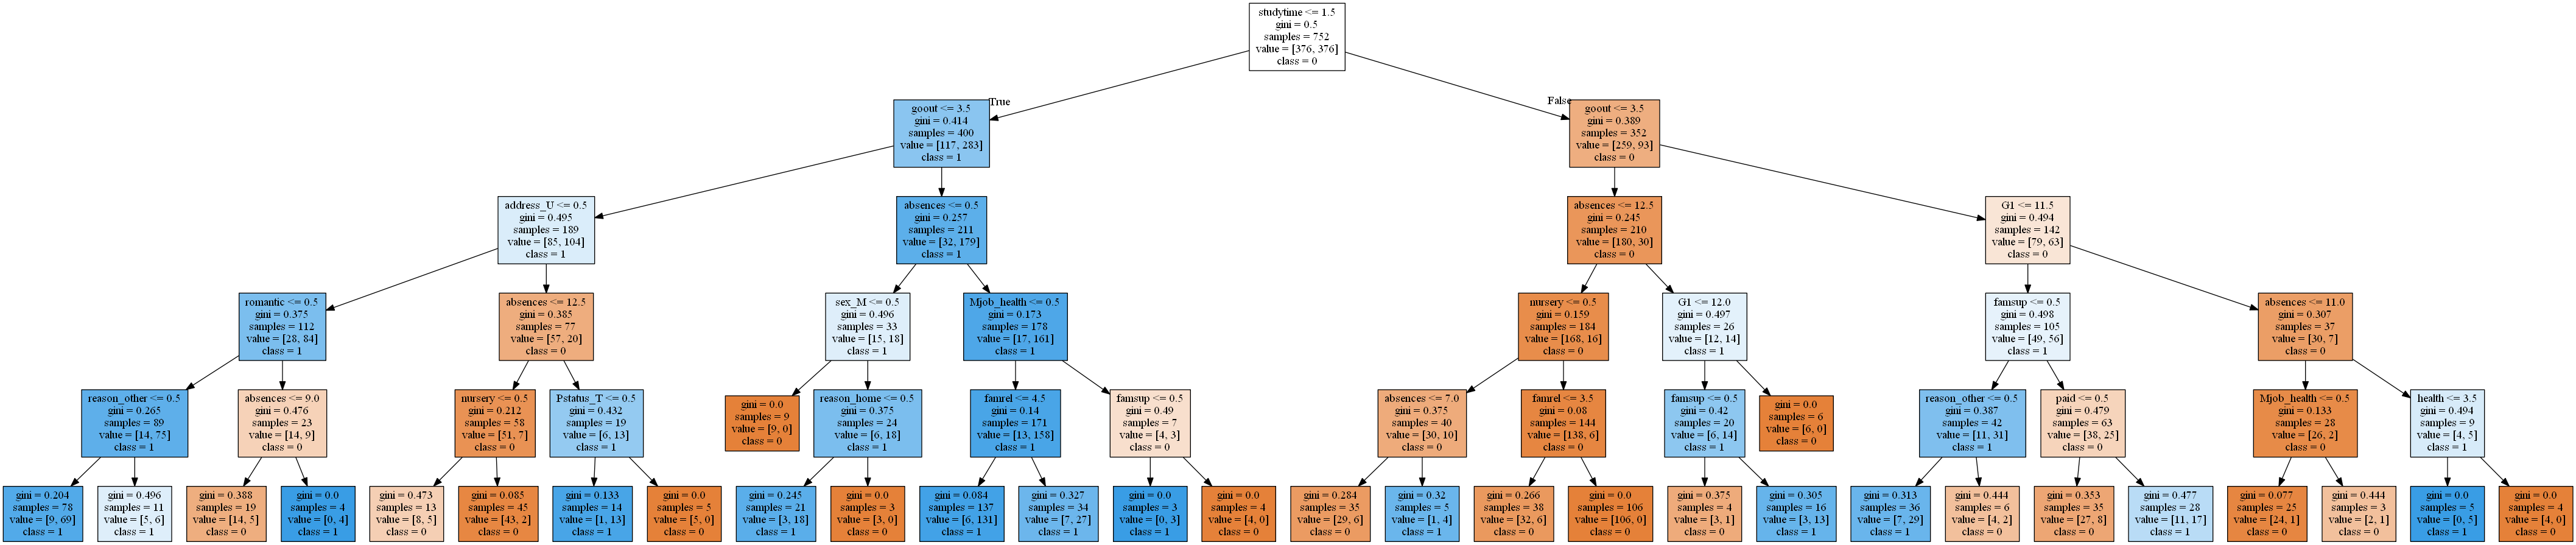

In [35]:
'''
The graphviz library is used to visualize the tree. 
'''

# Create DOT data
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=X_train_new.columns, 
                                class_names=['0', '1'], filled=True) #or use y_train.unique()

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

# Create PNG 
#graph.write_png("clf.png") #uncomment this line to save the plot as a .png file

In [36]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_order = np.array([X_new.columns.values])
i = np.argsort(importances)[::-1]
feature_order = feature_order[:,i]

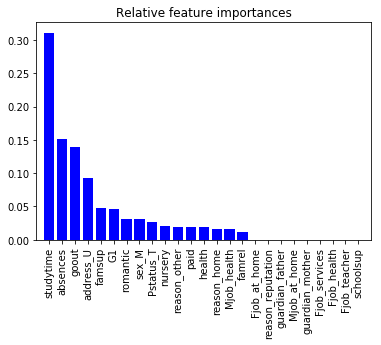

In [37]:
# Print the feature ranking
#print("Feature ranking:")

#for f in range(X.shape[1]):
#    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    
# Plot the feature importances of the forest
plt.figure()
plt.title("Relative feature importances")
plt.bar(range(X_new.shape[1]), importances[indices],
       color="b",  align="center")
plt.xticks(range(X_new.shape[1]), feature_order[0], rotation=90)
plt.xlim([-1, X_new.shape[1]])
plt.show()

In [38]:
print ("Accuracy is: ", (accuracy_score(y_test_new,y_pred_bal)*100).round(2))

Accuracy is:  75.38


### Support Vector Machine

### Imbalanced Data

In [39]:
svm_imb = SVC(gamma='auto', kernel='rbf') #define SVM classifier 
svm_imb.fit(X_train_new, y_train_new) #fit model to (imbalanced) training data

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [40]:
y_pred_svm_imb = svm_imb.predict(X_test_new)

In [41]:
print ("Accuracy is: ", (accuracy_score(y_test, y_pred_svm_imb)*100).round(2))

Accuracy is:  80.9


### Balanced Data

In [42]:
svm_bal = SVC(gamma='auto', kernel='rbf') #define SVM classifier 
svm_bal.fit(X_sm, y_sm) #fit model to (balanced) training data

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [43]:
y_pred_svm_bal = svm_bal.predict(X_test_new)

In [44]:
print ("Accuracy is: ", (accuracy_score(y_test_new, y_pred_svm_bal)*100).round(2))

Accuracy is:  85.43


2nd classifier that outputs probabilites instead of absolute values.

In [45]:
svm_bal_proba = SVC(gamma='auto', probability=True)
svm_bal_proba.fit(X_sm, y_sm)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [46]:
y_predProba_svm_bal = svm_bal_proba.predict_proba(X_test_new)

### Logistic Regression

### Imbalanced Data

In [47]:
lr_imb = LogisticRegression(random_state=42, solver='lbfgs') #define Logistic Regression classifier
lr_imb.fit(X_train_new, y_train_new) #fit LR model to the imbalanced training data

D:\Application\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [48]:
y_pred_lr_imb = lr_imb.predict(X_test_new)

In [49]:
print ("Accuracy is: ", (accuracy_score(y_test_new, y_pred_lr_imb)*100).round(2))

Accuracy is:  85.43


### Balanced Data

In [50]:
lr_bal = LogisticRegression(random_state=42, solver='lbfgs') #define Logistic Regression classifier
lr_bal.fit(X_sm, y_sm) #fit LR model to the balanced SMOTE training data

D:\Application\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [51]:
y_pred_lr_bal = lr_bal.predict(X_test_new)

In [52]:
print ("Accuracy is: ", (accuracy_score(y_test_new, y_pred_lr_bal)*100).round(2))

Accuracy is:  80.9


2nd output that uses probabilities.

In [53]:
y_predProba_lr = lr_bal.predict_proba(X_test_new)

## Evaluation

### Confusion Matrix

In [54]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

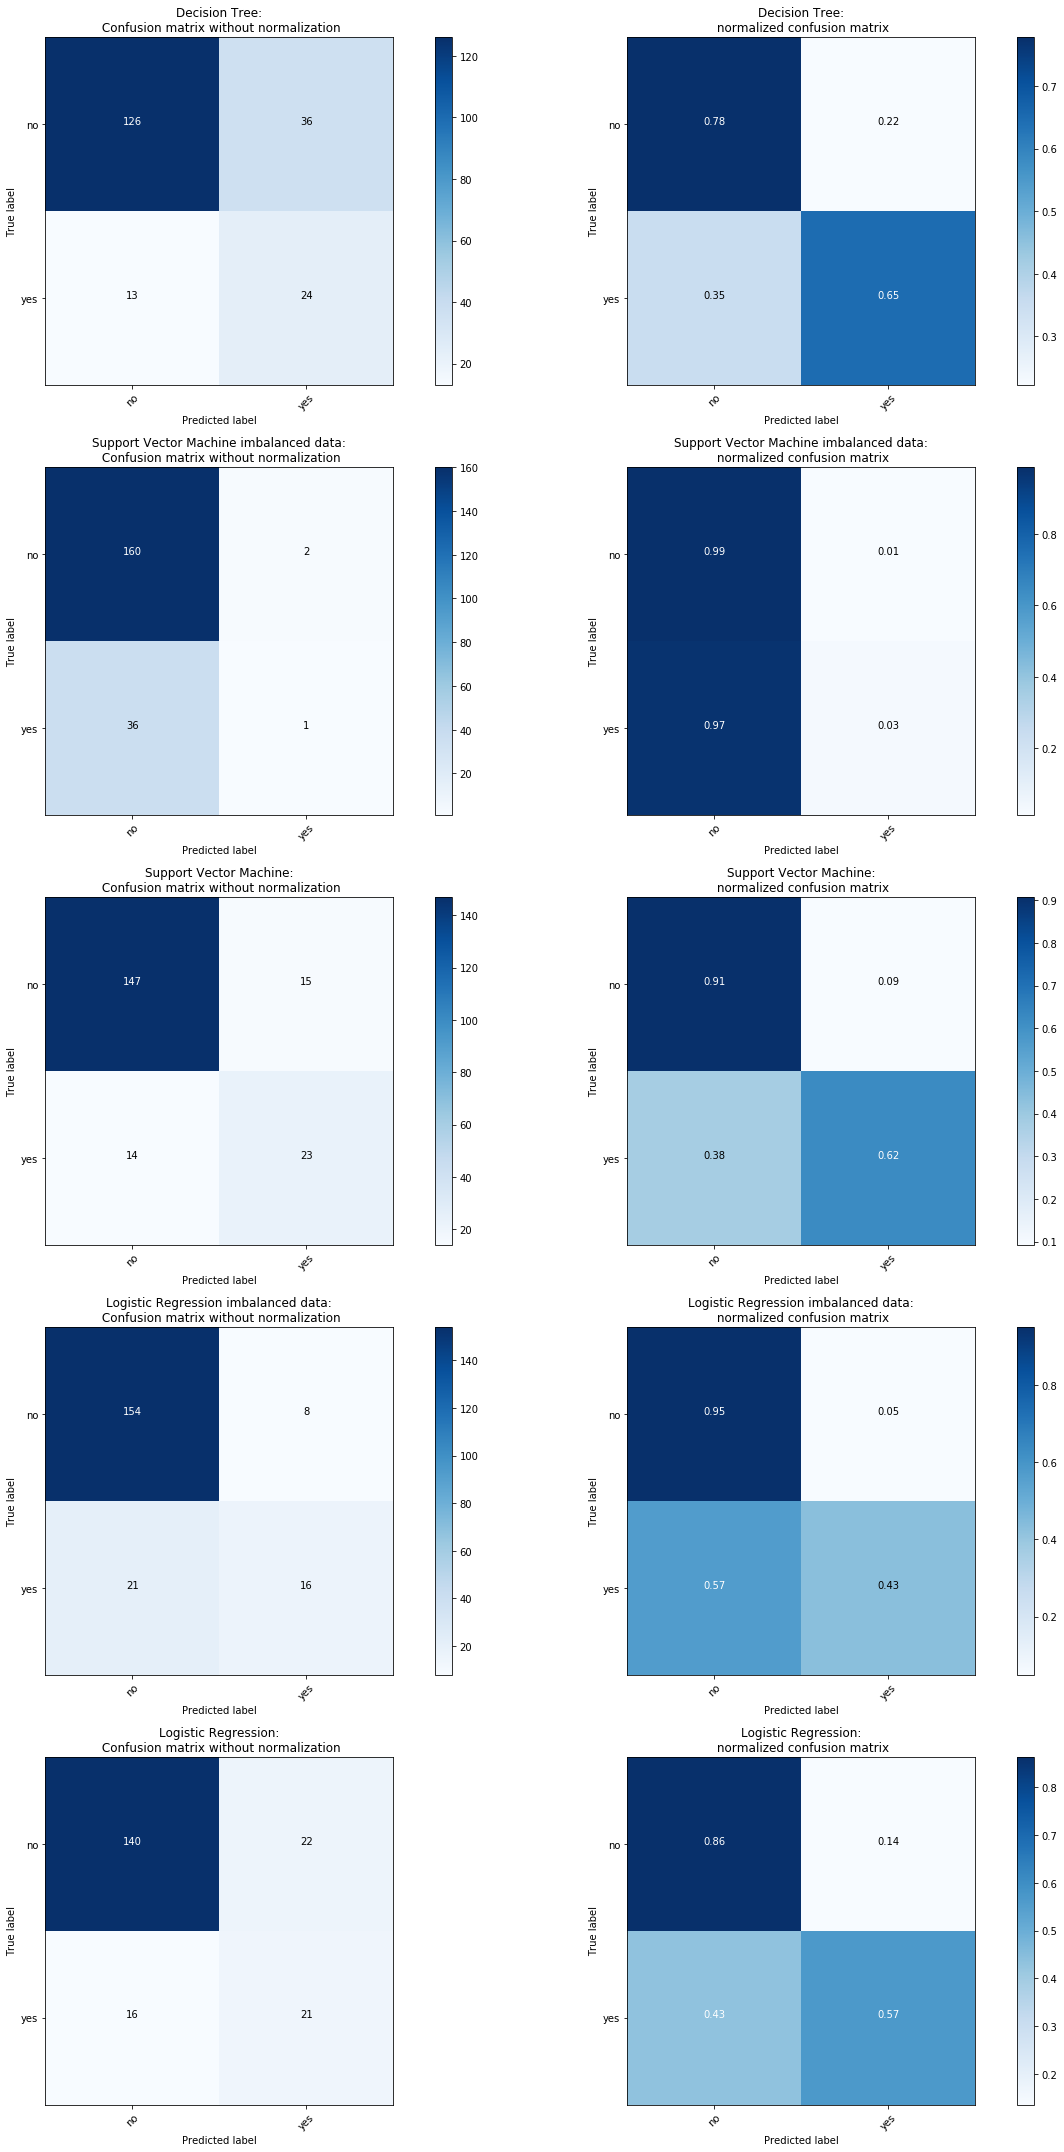

In [55]:
# Compute confusion matrix
class_names = ['no', 'yes']
cnf_matrix_tree = confusion_matrix(y_test_new, y_pred_bal)
cnf_matrix_svm_imb = confusion_matrix(y_test_new, y_pred_svm_imb)
cnf_matrix_svm = confusion_matrix(y_test_new, y_pred_svm_bal)
cnf_matrix_lr_imb = confusion_matrix(y_test_new, y_pred_lr_imb)
cnf_matrix_lr = confusion_matrix(y_test_new, y_pred_lr_bal)

np.set_printoptions(precision=2)

plt.figure(figsize=(20, 30))

#Plot Decision Tree balanced confusion matrix
plt.subplot(521) 
plot_confusion_matrix(cnf_matrix_tree, classes=class_names,
                      title='Decision Tree:\n Confusion matrix without normalization')

#Plot Decision Tree balanced confusion matrix
plt.subplot(522)
plot_confusion_matrix(cnf_matrix_tree, classes=class_names, normalize=True,
                      title='Decision Tree:\n normalized confusion matrix')

#Plot SVM imbalanced confusion matrix
plt.subplot(523) 
plot_confusion_matrix(cnf_matrix_svm_imb, classes=class_names,
                      title='Support Vector Machine imbalanced data:\n Confusion matrix without normalization')

#Plot SVM imbalanced normalized confusion matrix
plt.subplot(524) 
plot_confusion_matrix(cnf_matrix_svm_imb, classes=class_names, normalize=True,
                      title='Support Vector Machine imbalanced data:\n normalized confusion matrix')

#Plot SVM balanced confusion matrix
plt.subplot(525) 
plot_confusion_matrix(cnf_matrix_svm, classes=class_names,
                      title='Support Vector Machine:\n Confusion matrix without normalization')

#Plot SVM balanced normalized confusion matrix
plt.subplot(526) 
plot_confusion_matrix(cnf_matrix_svm, classes=class_names, normalize=True,
                      title='Support Vector Machine:\n normalized confusion matrix')

#Plot Logistic Regression (imbalanced) confusion matrix
plt.subplot(527) 
plot_confusion_matrix(cnf_matrix_lr_imb, classes=class_names,
                      title='Logistic Regression imbalanced data:\n Confusion matrix without normalization')

#Plot Logistic Regression (imbalanced) normalized onfusion matrix
plt.subplot(528) 
plot_confusion_matrix(cnf_matrix_lr_imb, classes=class_names, normalize=True,
                      title='Logistic Regression imbalanced data:\n normalized confusion matrix')


#Plot Logistic Regression (balanced) confusion matrix
plt.subplot(529) 
plot_confusion_matrix(cnf_matrix_lr, classes=class_names,
                      title='Logistic Regression:\n Confusion matrix without normalization')

#Plot Logistic Regression (balanced) normalized onfusion matrix
plt.subplot(5,2,10) 
plot_confusion_matrix(cnf_matrix_lr, classes=class_names, normalize=True,
                      title='Logistic Regression:\n normalized confusion matrix')

plt.show()

### AUC and ROC

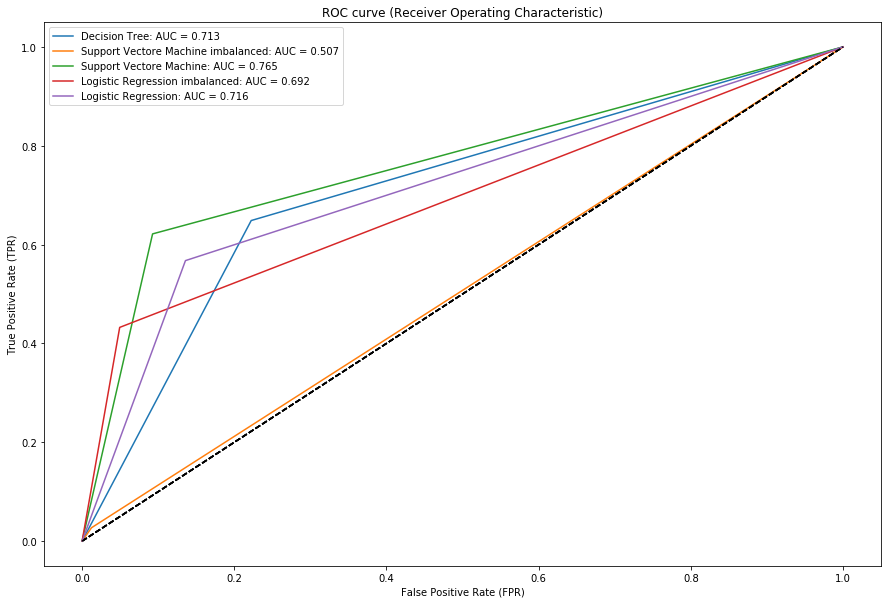

In [56]:
plt.figure(figsize=(15,10))

for test, pred, num, name in zip([y_test_new, y_test_new, y_test_new, y_test_new, y_test_new], [y_pred_bal, y_pred_svm_imb, y_pred_svm_bal, y_pred_lr_imb ,y_pred_lr_bal], range(1,6), ['Decision Tree', 'Support Vectore Machine imbalanced','Support Vectore Machine', 'Logistic Regression imbalanced','Logistic Regression']):
    fpr, tpr, thresholds = roc_curve(test, pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='{}: AUC = {}'.format(name, round(roc_auc, 3)))
    plt.legend(loc='best')
    plt.plot([0,1],[0,1],color='black', linestyle='--')

plt.title('ROC curve (Receiver Operating Characteristic)')    
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')

plt.show()